In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Exploration

In [6]:
data = pd.read_table("biaseddata.csv", sep='\t', index_col=0)
# data = pd.read_table("processedbiasdata.csv", sep='\t', index_col=0)
data

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,maggie clark pew SOURCE staff writer 21 states...,600,0.0,0.0,Neutral,0,0
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral,washington -- the senate judiciary committee a...,600,0.0,0.0,Neutral,0,0
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"parts of obamacare are starting to fray, even ...",600,0.0,0.0,Neutral,0,0
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12345,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,president obama won reelection in part by beat...,600,0.5,-0.5,Liberal,1,1
12346,http://news.yahoo.com/republicans-hatred-obama...,Opinion,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,"red-faced republicans, circling and preparing ...",600,0.5,-0.5,Liberal,1,1
12347,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,Neutral,Neutral,rep. steve stockman’s moment as a viable senat...,600,0.0,0.0,Neutral,0,0
12348,http://www.washingtonpost.com/opinions/ej-dion...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,we interrupt this highly partisan and ideologi...,600,0.5,-0.5,Liberal,1,1


In [7]:
data.shape

(12350, 14)

In [8]:
# tfdf = data[['article','biaslabel']]
tfdf = data.sample(frac=1)
tfdf['text'] = data['article']
tfdf['label'] = data['biaslabel']
# tfdf['label'] = data['democrat.vote']
# tfdf = tfdf[['text','label']]
# tfdf = tfdf.sample(frac=1)
tfdf = tfdf.reset_index(drop=True)

print(tfdf.shape)
tfdf.head()

(12350, 16)


,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
0,http://www.washingtonpost.com/politics/obama-v...,News,1,Democrat Scandals,None,SomewhatNegative,Neutral,during a joint press conference with turkish p...,600,-0.5,0.0,Somewhat Conservative,1,-1,during a joint press conference with turkish p...,Somewhat Conservative
1,http://www.huffingtonpost.com/2013/06/06/ny-ti...,News,1,Civil Rights,National Security,Negative,Neutral,the times became one of the more influential v...,285,-1.0,0.0,Conservative,1,-1,the times became one of the more influential v...,Conservative
2,http://www.foxnews.com/politics/2013/11/28/dem...,Opinion,1,Elections,Healthcare,SomewhatNegative,Neutral,a month after emerging from a government shutd...,600,-0.5,0.0,Somewhat Conservative,1,-1,a month after emerging from a government shutd...,Somewhat Conservative
3,http://www.foxnews.com/opinion/2013/04/23/immi...,Opinion,0,Civil Rights,None,SomewhatNegative,SomewhatPositive,americans believe in the value of immigration....,600,-0.5,0.5,Conservative,1,-1,americans believe in the value of immigration....,Conservative
4,http://www.washingtonpost.com/blogs/plum-line/...,News,0,Healthcare,None,Neutral,SomewhatNegative,looking at the polls in that light suddenly sh...,234,0.0,-0.5,Somewhat Liberal,1,1,looking at the polls in that light suddenly sh...,Somewhat Liberal


In [9]:
one_hot_encoded = pd.get_dummies(tfdf['label'])
col_names = list(one_hot_encoded.columns)

# tfdf = pd.concat([tfdf, one_hot_encoded], axis =1)
# tfdf

In [10]:
col_names

['Conservative',
 'Liberal',
 'Neutral',
 'Somewhat Conservative',
 'Somewhat Liberal',
 'Very Conservative',
 'Very Liberal']

In [11]:
tfdf = tfdf[(tfdf['label']!='Somewhat Conservative') & (tfdf['label']!='Somewhat Liberal')]
tfdf

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
1,http://www.huffingtonpost.com/2013/06/06/ny-ti...,News,1,Civil Rights,National Security,Negative,Neutral,the times became one of the more influential v...,285,-1.0,0.0,Conservative,1,-1,the times became one of the more influential v...,Conservative
3,http://www.foxnews.com/opinion/2013/04/23/immi...,Opinion,0,Civil Rights,None,SomewhatNegative,SomewhatPositive,americans believe in the value of immigration....,600,-0.5,0.5,Conservative,1,-1,americans believe in the value of immigration....,Conservative
5,http://www.usatoday.com/story/opinion/2013/02/...,other,1,Economy,Economy,Neutral,Neutral,fredric rolando the effort by postmaster gene...,390,0.0,0.0,Neutral,0,0,fredric rolando the effort by postmaster gene...,Neutral
6,http://www.huffingtonpost.com/2013/05/01/pat-t...,Opinion,1,Gun Rights Regulation,None,SomewhatPositive,Negative,sen. pat toomey (r-pa.) revealed that some mem...,398,0.5,-1.0,Very Liberal,1,1,sen. pat toomey (r-pa.) revealed that some mem...,Very Liberal
7,http://www.foxnews.com/us/2013/07/05/terrorist...,News,0,National Security,International News,Neutral,Neutral,a kansas city man and two other aspiring holy ...,600,0.0,0.0,Neutral,0,0,a kansas city man and two other aspiring holy ...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12342,http://news.yahoo.com/world-welcomes-us-budget...,News,1,Economy,None,Neutral,Neutral,london (ap) — the world's disbelief at the pol...,600,0.0,0.0,Neutral,0,0,london (ap) — the world's disbelief at the pol...,Neutral
12345,http://www.breitbart.com/Big-Journalism/2013/0...,News,0,Education,None,Neutral,Neutral,the mainstream media in the united states have...,295,0.0,0.0,Neutral,0,0,the mainstream media in the united states have...,Neutral
12347,http://news.yahoo.com/nc-protests-split-bibles...,News,0,Civil Rights,None,Neutral,Neutral,"raleigh, n.c. (ap) — over the last two months,...",600,0.0,0.0,Neutral,0,0,"raleigh, n.c. (ap) — over the last two months,...",Neutral
12348,http://www.nytimes.com/2013/12/01/us/politics/...,News,1,Healthcare,None,Neutral,Neutral,when the problems occur — and they still do — ...,386,0.0,0.0,Neutral,0,0,when the problems occur — and they still do — ...,Neutral


<AxesSubplot:>

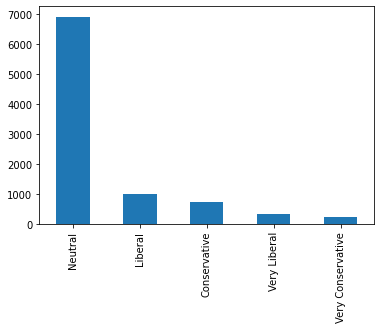

In [12]:
tfdf["label"].value_counts().plot.bar()

In [13]:
tfdf["label"] =  tfdf.apply(lambda row: "Biased" if row["label"]!="Neutral" else "Neutral", axis = 1)
tfdf

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
1,http://www.huffingtonpost.com/2013/06/06/ny-ti...,News,1,Civil Rights,National Security,Negative,Neutral,the times became one of the more influential v...,285,-1.0,0.0,Conservative,1,-1,the times became one of the more influential v...,Biased
3,http://www.foxnews.com/opinion/2013/04/23/immi...,Opinion,0,Civil Rights,None,SomewhatNegative,SomewhatPositive,americans believe in the value of immigration....,600,-0.5,0.5,Conservative,1,-1,americans believe in the value of immigration....,Biased
5,http://www.usatoday.com/story/opinion/2013/02/...,other,1,Economy,Economy,Neutral,Neutral,fredric rolando the effort by postmaster gene...,390,0.0,0.0,Neutral,0,0,fredric rolando the effort by postmaster gene...,Neutral
6,http://www.huffingtonpost.com/2013/05/01/pat-t...,Opinion,1,Gun Rights Regulation,None,SomewhatPositive,Negative,sen. pat toomey (r-pa.) revealed that some mem...,398,0.5,-1.0,Very Liberal,1,1,sen. pat toomey (r-pa.) revealed that some mem...,Biased
7,http://www.foxnews.com/us/2013/07/05/terrorist...,News,0,National Security,International News,Neutral,Neutral,a kansas city man and two other aspiring holy ...,600,0.0,0.0,Neutral,0,0,a kansas city man and two other aspiring holy ...,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12342,http://news.yahoo.com/world-welcomes-us-budget...,News,1,Economy,None,Neutral,Neutral,london (ap) — the world's disbelief at the pol...,600,0.0,0.0,Neutral,0,0,london (ap) — the world's disbelief at the pol...,Neutral
12345,http://www.breitbart.com/Big-Journalism/2013/0...,News,0,Education,None,Neutral,Neutral,the mainstream media in the united states have...,295,0.0,0.0,Neutral,0,0,the mainstream media in the united states have...,Neutral
12347,http://news.yahoo.com/nc-protests-split-bibles...,News,0,Civil Rights,None,Neutral,Neutral,"raleigh, n.c. (ap) — over the last two months,...",600,0.0,0.0,Neutral,0,0,"raleigh, n.c. (ap) — over the last two months,...",Neutral
12348,http://www.nytimes.com/2013/12/01/us/politics/...,News,1,Healthcare,None,Neutral,Neutral,when the problems occur — and they still do — ...,386,0.0,0.0,Neutral,0,0,when the problems occur — and they still do — ...,Neutral


<AxesSubplot:>

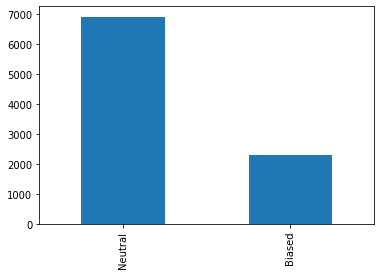

In [14]:
tfdf["label"].value_counts().plot.bar()

In [15]:
biaseddata = tfdf[tfdf['label']=="Biased"]
biaseddata.shape

(2306, 16)

In [16]:
neutraldata = tfdf[tfdf['label']=="Neutral"][:biaseddata.shape[0]]
neutraldata.shape

(2306, 16)

In [17]:
tfdf = pd.concat([biaseddata,neutraldata])
tfdf = tfdf.sample(frac=1)
tfdf

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,text,label
2475,http://www.latimes.com/news/politics/la-pn-ame...,other,0,None,None,Neutral,Neutral,"washington – americans are exercising more, bu...",600,0.0,0.0,Neutral,0,0,"washington – americans are exercising more, bu...",Neutral
2852,http://www.washingtonpost.com/national/health-...,other,1,None,None,Neutral,Neutral,"bebe bahnsen remembers the night, alone in her...",600,0.0,0.0,Neutral,0,0,"bebe bahnsen remembers the night, alone in her...",Neutral
1922,http://www.foxnews.com/politics/2013/07/08/rep...,News,0,Healthcare,Economy,SomewhatNegative,SomewhatPositive,house republicans are escalating their scrutin...,500,-0.5,0.5,Conservative,1,-1,house republicans are escalating their scrutin...,Biased
187,http://www.foxnews.com/opinion/2013/12/24/army...,News,0,Civil Rights,None,Neutral,Neutral,don’t say christmas. that’s the message that ...,542,0.0,0.0,Neutral,0,0,don’t say christmas. that’s the message that ...,Neutral
8255,http://www.dailykos.com/story/2013/07/15/12238...,Opinion,0,Economy,Education,SomewhatPositive,Negative,sen. marco rubio sen. marco rubio for presid...,439,0.5,-1.0,Very Liberal,1,1,sen. marco rubio sen. marco rubio for presid...,Biased
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,http://www.huffingtonpost.com/2013/07/08/gop-w...,News,1,Economy,None,SomewhatPositive,SomewhatNegative,washington -- the house appropriations committ...,600,0.5,-0.5,Liberal,1,1,washington -- the house appropriations committ...,Biased
963,http://www.dailykos.com/story/2013/10/21/12494...,News,0,Economy,Healthcare,Neutral,Neutral,our story so far: those who enroll in medicaid...,600,0.0,0.0,Neutral,0,0,our story so far: those who enroll in medicaid...,Neutral
2086,http://www.breitbart.com/Big-Journalism/2013/0...,Opinion,1,Democrat Scandals,None,Negative,Positive,eight months into president george w. bush’s s...,473,-1.0,1.0,Very Conservative,1,-1,eight months into president george w. bush’s s...,Biased
2997,http://www.foxnews.com/politics/2013/02/03/flo...,News,1,Economy,None,Neutral,Neutral,a florida republican congressman is welcoming ...,395,0.0,0.0,Neutral,0,0,a florida republican congressman is welcoming ...,Neutral


In [18]:
train_section = tfdf[:4000]
val_section = tfdf[4000:4500]
test_section = tfdf[4500:]

# train_section = tfdf[5000:8000]
# val_section = tfdf[8000:9000]
# test_section = tfdf[9000:]

# train_section = tfdf[:10000]
# val_section = tfdf[10000:12500]
# test_section = tfdf[12500:]

<AxesSubplot:>

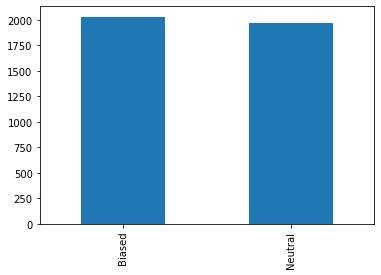

In [20]:
train_section["label"].value_counts().plot.bar()

<AxesSubplot:>

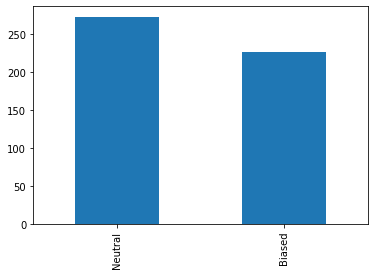

In [21]:
val_section["label"].value_counts().plot.bar()

<AxesSubplot:>

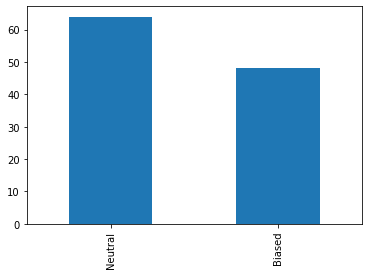

In [22]:
test_section["label"].value_counts().plot.bar()

In [23]:
np.unique(tfdf.label)

array(['Biased', 'Neutral'], dtype=object)

In [71]:
train_section.to_csv("train_dataset.csv", sep='\t')
val_section.to_csv("val_dataset.csv", sep='\t')
test_section.to_csv("test_dataset.csv", sep='\t')

In [34]:
model.save_pretrained(save_path)

In [77]:
tf.keras.backend.clear_session()